In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels as sm
# %matplotlib inline
pd.options.display.max_columns = None
def increase_figsize(N, plt=plt):
    params = plt.gcf() if type(plt) is type(pd) else plt
    axes = params.get_axes()
    plSize = params.get_size_inches()
    params.set_size_inches((plSize[0]*N, plSize[1]*N))
def increase_size_by(N, fontsize, plt=plt):
    params = plt.gcf() if type(plt) is type(pd) else plt
    axes = params.get_axes()
    plSize = params.get_size_inches()
    params.set_size_inches((plSize[0]*N, plSize[1]*N))
    for ax in axes:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
            
# Setting some default params. 
cbf = ['#377eb8', '#ff7f00', '#4daf4a',
        '#f781bf', '#a65628', '#984ea3',
        '#999999', '#e41a1c', '#dede00']
cbf_map = mpl.colors.ListedColormap(cbf)
rc = {'axes.facecolor': 'white', 'axes.edgecolor': '.15', 'axes.axisbelow': True, 'figure.facecolor': 'white',
      'axes.labelcolor': '.15',  'text.color': '.25',
      'patch.force_edgecolor': True, 'patch.edgecolor': 'w',
      'xtick.bottom': True, 'ytick.left': True, 'xtick.color': '.15', 'ytick.color': '.15',
      'grid.linestyle': '-', 'axes.grid': False, 'grid.color': '.8', 
      'font.size': 30, 
      'xtick.labelsize': 15, 'ytick.labelsize': 15, 
      'axes.titlesize': 22,
      'axes.labelsize': 15,
      'legend.fontsize': 18, 'legend.title_fontsize': 30,
      }
sns.set(rc=rc)
sns.set_palette(cbf)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
def percentage(x): 
    return x / x.sum()

from pandas.core.base import PandasObject

PandasObject.set_columns = lambda df, values: df.T.set_index(values).T


In [4]:
has_header = True  # this can be made with the preprocessing file 'patches/remove_double_genomes.py' or 'patches/summary'
data_folder = '/home/hielke/bep/res/'
fig_folder = '/home/hielke/bep/figs/FOR_PUB/'
first_order = 'A'
second_order = 0
save = False
title_mod = ""
def save_fig(ax=None, save=save, plt=plt, title=None):
    if not save: 
        return 
    
    if not ax: 
        ax = plt.gca()
        
    title = title or (g.fig._suptitle._text 
                      if type(ax) is sns.axisgrid.FacetGrid 
                      else ax.get_title())
    
    global second_order
    second_order += 1
    
    dest = fig_folder + first_order + str(second_order) + "___" \
        + title.replace(" ", "_") + ".png"
    plt.savefig(dest, format='png', bbox_inches='tight')
    print("figure saved in " + dest)

# READ IN DATA

In [5]:
if has_header:
    df = pd.read_csv(data_folder + 'hits.tsv.header', sep='\t', 
                    index_col=False, keep_default_na=False, 
                     dtype={'genome_id': str, 'spacer_pos': int, 'spacer_size': int}
                    ).set_index('genome_id')
else:
    df = pd.read_csv(data_folder + 'gene.matched.tsv.smallarraycheck', sep='\t', 
                 names=['genome_key', 'genome_id', 'contig_hit', 'c_1', 'c_2', 'spacer_id', 'hit_ident', 'spacer_size', 
                        'contig_size', '3_prime', '5_prime', 'array_id', 'array_size', 'array_confid', 'repeat_size', 'array_type', 'genome_type',
                        'PAM_confid', 'poss_PAM', 'PAM_side', 'phage_class', 'with_phage',  'gene_hit', 'gene_id', 'gene_class'],
                index_col=False, keep_default_na=False, 
                     dtype={'genome_id': str}).set_index('genome_id')
df.drop(['3_prime', '5_prime', 'genome_key',], axis=1, inplace=True)
df.head()

,contig_hit,c_1,c_2,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,spacer_pos,rel_spacer_pos,name_spacer_pos
genome_id,,,,,,,,,,,,,,,,,,,,,,,,
100053.4,JQGS01000037,11782,11751,JQGS01000065_1_1,100.00,32,53765,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,3,CTTGCTAAAG,3,2,2,RNA+,JQGS01000037_19,UNKNOWN,1,0.000000,leader
100053.4,JQGS01000037,13121,13089,JQGS01000134_1_4,100.00,33,53765,JQGS01000134_1,5,3.02,28,NA,CAS-TypeIE,2,AGGAACTCAT,3,2,2,RNA+,JQGS01000037_20,UNKNOWN,4,0.750000,middle
100053.4,JQGS01000037,1789,1757,JQGS01000065_1_2,100.00,33,53765,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,3,CTTGAATCCG,3,2,2,INTERGENIC,NULL,NULL,2,0.090909,middle
100053.4,JQGS01000037,22144,22112,JQGS01000134_1_5,96.97,33,53765,JQGS01000134_1,5,3.02,28,NA,CAS-TypeIE,0,ATTTCGAGGT,3,2,2,RNA-,JQGS01000037_36,UNCLASSIFIED,5,1.000000,tail
100053.4,JQGS01000037,24519,24550,JQGS01000065_1_12,100.00,32,53765,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,3,CTTCGAATTC,3,2,2,RNA+,JQGS01000037_38,UNCLASSIFIED,12,1.000000,tail


In [6]:
ident = 90
df_sel = df.query('hit_ident > @ident and gene_id != "NULL"')
dfgenehits = df_sel.groupby([df_sel.index, 'gene_id']).nth(0)
    
if True:
    import csv
    with open(data_folder + 'selection_for_gene_classification', 'w') as f:
        f.writelines(line + '\n' for line in set(df_sel.index))

In [7]:
# PERFORM SELECTION AS FOLLOWS:
# (NB: Slashes look like pipes when in italics, but are still slashes to indicate tabs.)
# alias mtawk="mawk -F '\t' -v OFS='\t'"
# mtawk 'FNR==NR{hits[$0]=1;next;} $1 in hits' selection_for_gene_classification gene_classification > gene_classification.sel
dfgenes = pd.read_csv(data_folder + 'gene_classification.sel.%d' % ident, sep='\t', 
                      names=['genome_id', 'gene_id', 's', 'e', 'side', 'gene_class'],
                      dtype={'genome_id': str}).set_index('genome_id')

In [8]:
gene_classes = dfgenes['gene_class'].value_counts()
all_genes = sum(gene_classes)

In [9]:
dfgenehits = df_sel.reset_index().groupby(['genome_id', 'gene_id']).first().reset_index().set_index('genome_id')

In [18]:
# GENE ENRICHEMENT
# UNIQUE GENES
# CHI SQUARE TEST
gene_class_hits = dfgenehits['gene_class'].value_counts()
all_gene_hits = sum(gene_class_hits)

expected_ratio = all_gene_hits / all_genes
not_hit_genes = all_genes - all_gene_hits

# gene_class_hits = gene_class_hits[gene_class_hits > 5]

# from scipy.stats.mstats import chisquare

alternative = 'less'

def binom_test(x):
    
    gene_name = x['index']
    all_genes = gene_classes[gene_name]
    genes_hit = x['gene_class']
    
    # We test if for a gene, the amount of genes that are hit is greater than expected.
    p = stats.binom_test(genes_hit, all_genes, expected_ratio, alternative=alternative)
    return p, gene_name

def fisher_exact(x):
    
    gene_name = x['index']
    all_this_gene = gene_classes[gene_name]
    genes_hit = x['gene_class']
    
    
    this_gene_not_hit = all_this_gene - genes_hit
    other_genes_hit = all_gene_hits - genes_hit
    other_genes_not_hit = not_hit_genes - this_gene_not_hit
    
    table = [[genes_hit, this_gene_not_hit], 
                                        [other_genes_hit, other_genes_not_hit]]
    
    odds_ratio, p = stats.fisher_exact(table,
                                       alternative=alternative)
    return p, gene_name
    
    
    

p_vals = gene_class_hits.reset_index().apply(fisher_exact, result_type='expand', axis=1)

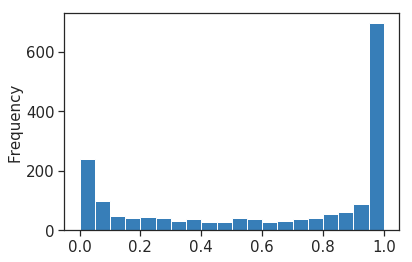

In [19]:
p_vals[0].plot.hist(bins=20)

In [21]:
from statsmodels.stats.multitest import fdrcorrection
pd.set_option('display.max_colwidth', 200)
p_corr = p_vals[fdrcorrection(p_vals[0])[0]].rename(columns={0: 'p', 1: 'gene'}).merge(
    gene_class_hits.to_frame('count').reset_index().rename(columns={'index': 'gene'}), 
    how='left', on='gene').merge(
    gene_classes.to_frame('total_count').reset_index().rename(columns={'index': 'gene'})
    )
p_corr.sort_values(by='count', ascending=False).query('count >= 0')

,p,gene,count,total_count
0,1.385798e-04,Nucleotide-diphospho-sugar transferases,36,112682
2,6.701103e-58,ABC transporter-like,34,403619
1,7.216169e-18,FAD/NAD(P)-binding domain superfamily,34,198318
3,2.891379e-45,"ABC transporter type 1, transmembrane domain MetI-like",24,304065
4,2.623749e-03,CBS domain,23,71153
5,6.613214e-05,GGDEF domain,20,76924
6,4.417161e-46,Major facilitator superfamily domain,19,287236
7,5.473658e-09,"Transcription regulator LuxR, C-terminal",16,92391
8,6.671646e-07,"ABC transporter type 1, transmembrane domain superfamily",16,79797
9,2.026395e-33,"Signal transduction response regulator, receiver domain",16,215939


In [14]:
test = gene_class_hits.reindex(index=gene_classes.index, fill_value=0)
